#  Chess Pieces Detection and Classification - Demo


The goal of this project is to create a pipeline of chess pieces detection and classification without the use of deep learning architectures.

This notebook presents a demonstration of how the pipeline works in depth and showcases its performance compared to deep learning models.

Run the cells below to see the pipeline in action. The code is organized into sections for clarity and ease of understanding.

In [ ]:
# utils...

import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import src.detection as det
import src.svm_training as svm
from joblib import load

def detect_and_classify_pieces(img_path, model_path='model\\SVC_LDA.joblib', lda_path='model\\lda_transformer.joblib'):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (640, 480))
    img = img[10:-10, 5:-20]
    original = img.copy()
    # Show the original image
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Detect black and white pieces
    black_contours = det.detect_black_pieces(img)
    white_contours = det.detect_white_pieces(img)

    # Crop pieces using the crop_pieces function
    black_pieces = det.crop_pieces(img, black_contours, color='black')
    white_pieces = det.crop_pieces(img, white_contours, color='white')

    # Load the trained SVM and LDA models
    clf = load(model_path)
    lda = load(lda_path)

    # Function to classify pieces
    def classify_pieces(pieces, contours, color):
        for piece, contour in zip(pieces, contours):
            if piece is None or piece.size == 0:
                continue  # Skip invalid pieces
            x, y, w, h = cv2.boundingRect(contour)
            if color == 'black':
                padding_width = 0.25
                padding_height = 0.2
            else:
                padding_width = 0.25
                padding_height = 0.4
            features = svm.extract_features(piece)
            features_lda = lda.transform([features])
            label = clf.predict(features_lda)[0]
            extra_width = int(w * padding_width)
            extra_height = int(h * padding_height)
            x -= extra_width
            y -= extra_height
            w += extra_width
            h += extra_height
            cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(original, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 3)  # Black contour
            cv2.putText(original, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)  # White text

    # Classify and annotate black pieces
    classify_pieces(black_pieces, black_contours, color='black')

    # Classify and annotate white pieces
    classify_pieces(white_pieces, white_contours, color='white')

    # Display the original image with annotations
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## The Dataset

Here are some sample images of the dataset that we used

In [ ]:
image_paths = [
    "data\\raw\\IMG_0295_JPG.rf.8abd802272b965c843eb1ecbc8df4abc.jpg",
    "data\\raw\\de60ba81aa78387928e4bdc11f3be301_jpg.rf.0cd8adb84fce0b83ee30a5fbdb4c1c4b.jpg",
    "data\\raw\\c0d68e012bb93c14bc333fc1d5e52621_jpg.rf.47fcf95dac60ca78902fc86cca7eab28.jpg",
    "data\\raw\\IMG_0297_JPG.rf.2609f7e3ad4d54b19aafc0623f5a8510.jpg",
    "data\\raw\\8ec14357f5f18fb98db86e0283623150_jpg.rf.dc1f65d43628062fda98946db19045ef.jpg",
    "data\\raw\\f9a9a175f26d4b26bca3a5338cc1405e_jpg.rf.ec1a436f709ef7dc2e4f1fd3c9f6355e.jpg",
    "data\\raw\\f52e1873b8583f8bf4f7ddf6e9649f07_jpg.rf.48248922519cd3c8f36539bc09dd8528.jpg",
    "data\\raw\\c3e9e81ba1540aae7961a4d8d96600ba_jpg.rf.deda5846f9437d81262d2e25f5808e36.jpg",
    "data\\raw\\4894f034a55eaa9252cd261a62b11d27_jpg.rf.5821daba2605c369ab52a6c1d3485b2a.jpg"
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, img_path in zip(axes.flatten(), image_paths):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (640, 480))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()

As evident from the nine sample images, the dataset consists of pictures captured from a relatively consistent angle, with minimal variation in perspective. Additionally, the color distribution across all images is highly uniform—a factor that proved crucial for the effectiveness of our detection pipeline, which heavily relies on color-based segmentation.

## In-depth look at the hand-crafted **detection** pipeline

### Black Pieces
We took advantage of the strong contrast between the black chess pieces and the board background, allowing us to perform detection using only the grayscale channel of the image.

The detection pipeline for black pieces involved the following steps:

- Resize the image to **640×480 pixels** for consistency.
- Convert the image to **grayscale** to simplify processing.
- Apply a **median blur** with a 5×5 kernel to reduce noise and suppress light reflections on the pieces.
- Apply a **threshold** by keeping only pixel values in the range **0–55**, isolating dark regions.
- Perform **morphological closing** followed by **opening** (both using a 7×7 kernel) to clean up the binary mask and remove small artifacts.
- Extract **contours** from the resulting binary image.
- Filter the contours based on their **area** and **aspect ratio** to reduce false positives.
- Add **padding** to each bounding box and draw rectangles around the detected contours to localize the black pieces.


In [ ]:

def detect_black_pieces(img, threshold=55, min_area=150, max_area=2500):
    # Show the original image
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_gray, cmap='gray')
    plt.axis('off')
    plt.title('Grayscale Image')
    plt.show()

    # Apply median blur
    img_blur = cv2.medianBlur(img_gray, 5)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_blur, cmap='gray')
    plt.axis('off')
    plt.title('Median Blur 5x5')
    plt.show()

    # Apply threshold
    img_thresh = cv2.inRange(img_blur, 0, threshold)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_thresh, cmap='gray')
    plt.axis('off')
    plt.title('Masking 0-55')
    plt.show()

    # Apply morphological operations to remove noise
    kernel = np.ones((7, 7), np.uint8)
    img_close = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)  # Close
    plt.figure(figsize=(10, 8))
    plt.imshow(img_close, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Closing')
    plt.show()

    img_open = cv2.morphologyEx(img_close, cv2.MORPH_OPEN, kernel)  # Open
    plt.figure(figsize=(10, 8))
    plt.imshow(img_open, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Opening')
    plt.show()

    # Find contours of detected pieces
    contours, _ = cv2.findContours(img_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and height/width ratio
    contours = [c for c in contours
                if max_area > cv2.contourArea(c) > min_area
                and cv2.boundingRect(c)[2] <= cv2.boundingRect(c)[3] <= 3 * cv2.boundingRect(c)[2]]

    return contours


# example
img_path = "data\\raw\\IMG_0295_JPG.rf.8abd802272b965c843eb1ecbc8df4abc.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 480))
img = img[10:-10, 5:-20]
contours = detect_black_pieces(img)
img = det.draw_black_bounding_boxes(img, contours)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Black Pieces Detected')
plt.show()

## White Pieces


Detecting white pieces was more challenging than detecting black ones, primarily because white pieces tend to blend into the white squares of the chessboard background. As a result, simple grayscale thresholding was insufficient. Instead, we relied on color information in the HSV color space to better isolate white pieces.

The steps of the detection pipeline were as follows:

- Convert the input image to the **HSV color space**, which allows better separation of brightness and color information.
- Extract only the **Hue (H)** and **Value (V)** channels, which were the most effective in distinguishing white pieces from the background.
- Apply individual **thresholds** on both channels:
  - Keep Hue values in the range **23–36**.
  - Keep Value values in the range **64–191**.
- Combine the two binary masks using a **bitwise AND** operation to obtain a more precise segmentation mask.
- Apply **morphological opening and closing** (with a 5×5 kernel) to remove small noise and smooth the segmented regions.
- Find **contours** in the cleaned binary mask to identify candidate white pieces.
- Filter the contours based on their **area** and **aspect ratio** to reduce false positives.
- Add padding and draw **bounding boxes** around the detected contours to localize the white pieces.


In [ ]:

def detect_white_pieces(img, h_bounds=(23, 36), v_bounds=(64, 191), min_area=150, max_area=2500):
    # Convert to HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Split HSV channels and take only H and V
    h, _, v = cv2.split(img_hsv)

    # Apply threshold only on H and V channels
    h_mask = cv2.inRange(h, h_bounds[0], h_bounds[1])
    plt.figure(figsize=(10, 8))
    plt.imshow(h_mask, cmap='gray')
    plt.axis('off')
    plt.title('H Mask 23-36')
    plt.show()

    v_mask = cv2.inRange(v, v_bounds[0], v_bounds[1])
    plt.figure(figsize=(10, 8))
    plt.imshow(v_mask, cmap='gray')
    plt.axis('off')
    plt.title('V Mask 64-191')
    plt.show()

    # Combine masks
    mask = cv2.bitwise_and(h_mask, v_mask)
    plt.figure(figsize=(10, 8))
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Combined Mask')
    plt.show()

    # Apply morphological operations to remove noise
    kernel = np.ones((5, 5), np.uint8)
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Open
    plt.figure(figsize=(10, 8))
    plt.imshow(mask_open, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Opening')
    plt.show()

    mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel)  # Close
    plt.figure(figsize=(10, 8))
    plt.imshow(mask_close, cmap='gray')
    plt.axis('off')
    plt.title('Morphological Closing')
    plt.show()

    # Find contours of detected pieces
    contours, _ = cv2.findContours(mask_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    contours = [c for c in contours
                if max_area > cv2.contourArea(c) > min_area
                and cv2.boundingRect(c)[2] <= cv2.boundingRect(c)[3] <= 2.5 * cv2.boundingRect(c)[2]]

    return contours

# example
img_path = "data\\raw\\IMG_0294_JPG.rf.b7ae411904ff022e80b90f6267535f05.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 480))
img = img[10:-10, 5:-20]
contours = detect_white_pieces(img)
img = det.draw_white_bounding_boxes(img, contours)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('White Pieces Detected')
plt.show()

## Classification

### Data Preparation

We began by running our custom piece detection pipeline over the entire dataset. Each chessboard image was processed to extract bounding boxes corresponding to individual chess pieces. These cropped images were then manually labeled. We also discarded outliers and poor detections to ensure the quality of the training data.

---

### Model Selection

Given the structured nature of our features and the relatively small dataset, we opted for a **Support Vector Machine (SVM)** with a linear kernel as our classifier. To improve class separability and reduce dimensionality, we applied **Linear Discriminant Analysis (LDA)** prior to classification.

---

### Feature Extraction

Each labeled piece was transformed into a feature vector composed of:
- **HOG (Histogram of Oriented Gradients)** features to capture edge and shape information.
- **Hu Moments** to provide shape descriptors invariant to rotation, scale, and translation.

These features were concatenated into a single vector per sample.

---

### Performance Evaluation

We evaluated our model using **5-fold stratified cross-validation**. For each fold, we reported accuracy, the classification report, and the confusion matrix to assess both overall and per-class performance. This helped us identify which classes were more prone to confusion and whether our features generalized well across the dataset.

---

### Live SVM Training

In this section, we demonstrate how fast and effective our SVM-based classifier is by training it live on the extracted chess piece dataset.

As specified above, the model uses a combination of HOG features and Hu Moments, followed by dimensionality reduction with LDA and classification using a linear SVM.

To showcase the performance, we use 5-fold cross-validation and display the following for the best model:

- Accuracy score  
- Confusion matrix (visualized)  
- Classification report



Loading data and extracting features...
Dataset size: 1724 samples
Training set size: 1379 samples
Testing set size: 345 samples

Fold 1/5
LDA reduced to 11 features
Accuracy: 0.9797
Classification Report:
              precision    recall  f1-score   support

black_bishop       1.00      1.00      1.00        11
  black_king       0.95      0.95      0.95        22
black_knight       1.00      1.00      1.00        31
  black_pawn       0.99      1.00      1.00       102
 black_queen       0.89      0.80      0.84        10
  black_rook       0.95      0.95      0.95        21
white_bishop       1.00      1.00      1.00         8
  white_king       0.95      0.95      0.95        22
white_knight       0.96      1.00      0.98        25
  white_pawn       1.00      1.00      1.00        63
 white_queen       0.92      0.92      0.92        13
  white_rook       1.00      0.94      0.97        17

    accuracy                           0.98       345
   macro avg       0.97      0.96   

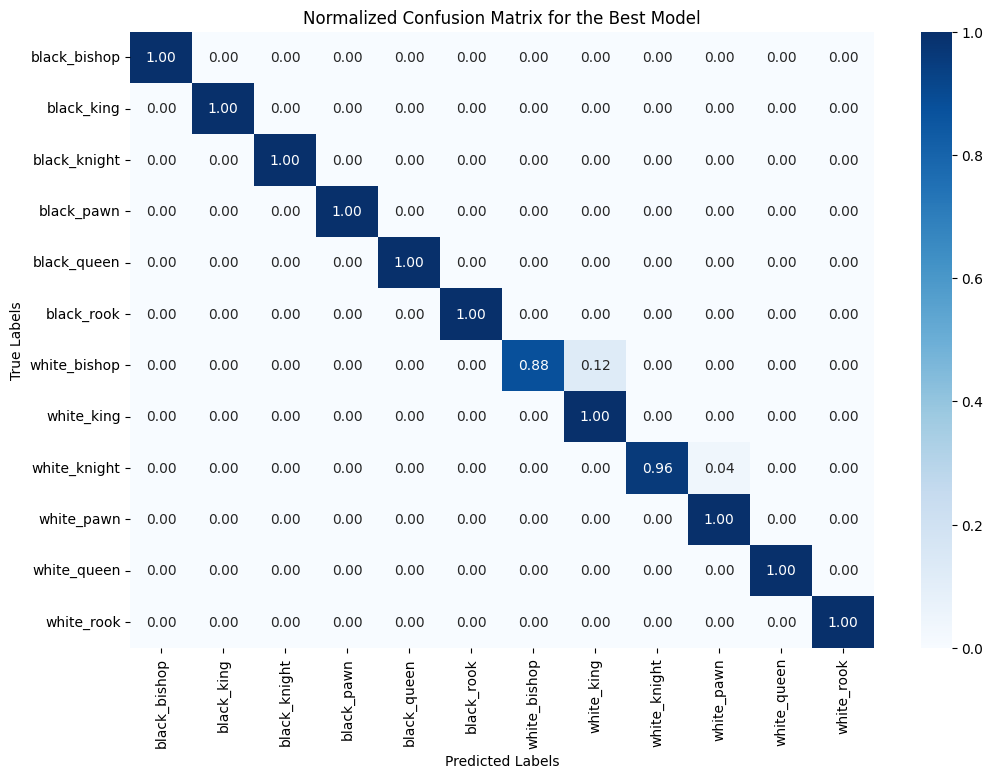

In [39]:
from src.svm_training import load_data, extract_features
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import dump
import matplotlib.pyplot as plt

# Load data
print("Loading data and extracting features...")
X, y = load_data()
print(f"Dataset size: {len(X)} samples")
if len(X) == 0:
    raise ValueError("No data found. Please check your dataset path and labels.")
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# Perform 5-fold cross-validation and train the SVM
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)
accuracies = []
best_acc = -1
best_model = None
best_lda = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}/{k}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Apply LDA for dimensionality reduction
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_val_lda = lda.transform(X_val)
    print(f"LDA reduced to {X_train_lda.shape[1]} features")

    # Train SVM
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train_lda, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_val_lda)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_model = clf
        best_lda = lda

    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

# Display stats for best model
print(f"\nBest Model Accuracy: {best_acc:.4f}")
print("Best Model Classification Report on test set:")
best_y_pred = best_model.predict(best_lda.transform(X_test))
print(classification_report(y_test, best_y_pred))

# Save the best model and LDA transformer

model_path = "best_svm_model.joblib"
lda_path = "best_lda_transformer.joblib"

dump(best_model, model_path)
dump(best_lda, lda_path)

print(f"Best model saved to {model_path}")
print(f"LDA transformer saved to {lda_path}")


# Plot the confusion matrix as a heatmap
conf_matrix = confusion_matrix(y_test, best_y_pred)
# Normalize the confusion matrix by row (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix for the Best Model')
plt.show()




In the above demonstration, we first split the whole dataset into training(80%) and testing set(20%). We then trained the model on the training set and evaluated it on the testing set. 
If everything goes according to plan, we should see a confusion matrix with a high diagonal and low off-diagonal values, indicating that the model is performing well on the test set. 

## Demonstration of hand-crafted pipeline

We will now use a selection of images from the dataset to showcase the performance of our hand-crafted pipeline. These examples include both straightforward cases, where the pipeline performs exceptionally well, and challenging scenarios that test its robustness. By visualizing the results, we aim to highlight the pipeline's ability to accurately detect and classify chess pieces under varying conditions, but also its difficulties in certain situations, such as overlapping pieces.
The classification model is the one trained during this demo, and it will be used to classify the pieces detected in the images, hopefully obtaining good results.
The images will be processed in the same way as during training, and the results will be displayed with bounding boxes around the detected pieces, along with their predicted classes. 

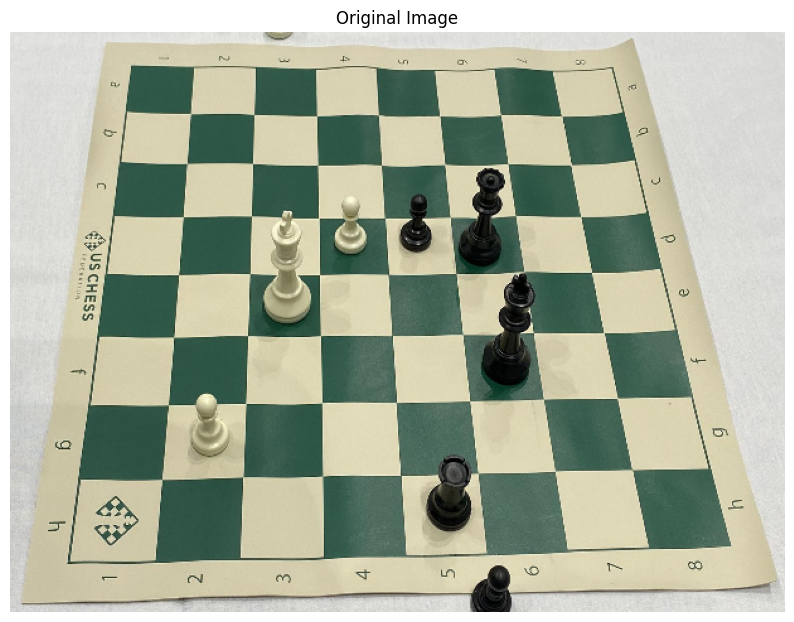

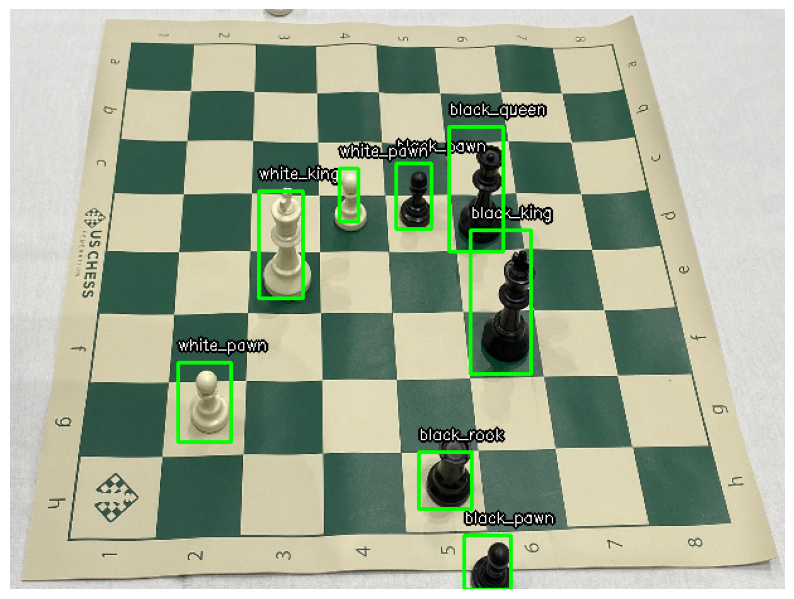

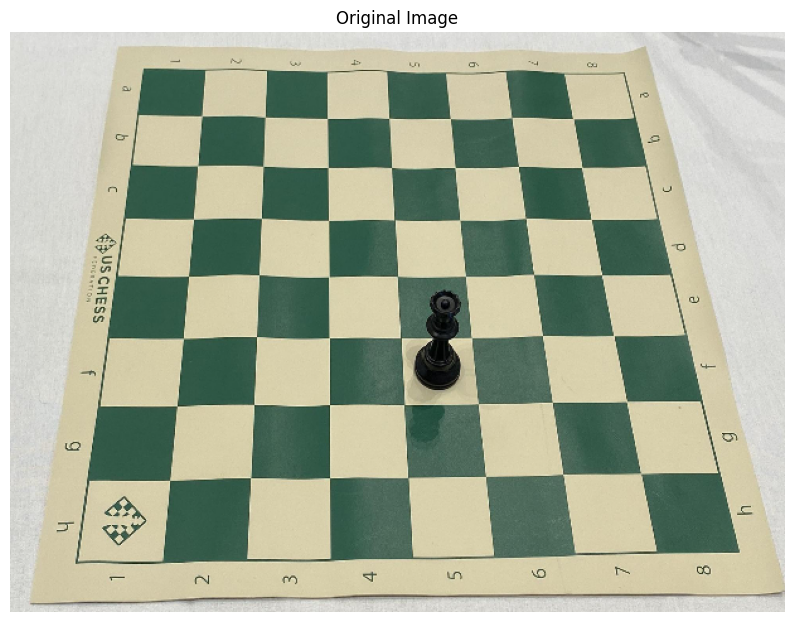

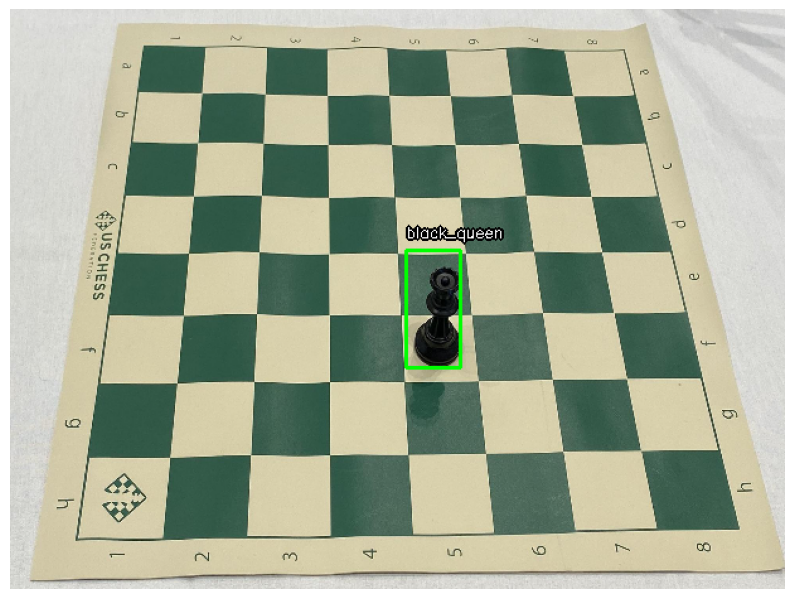

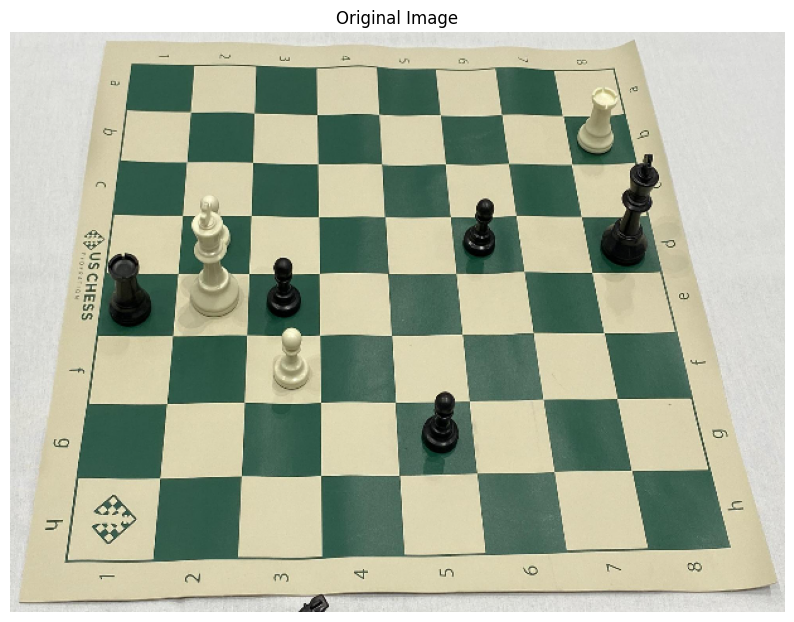

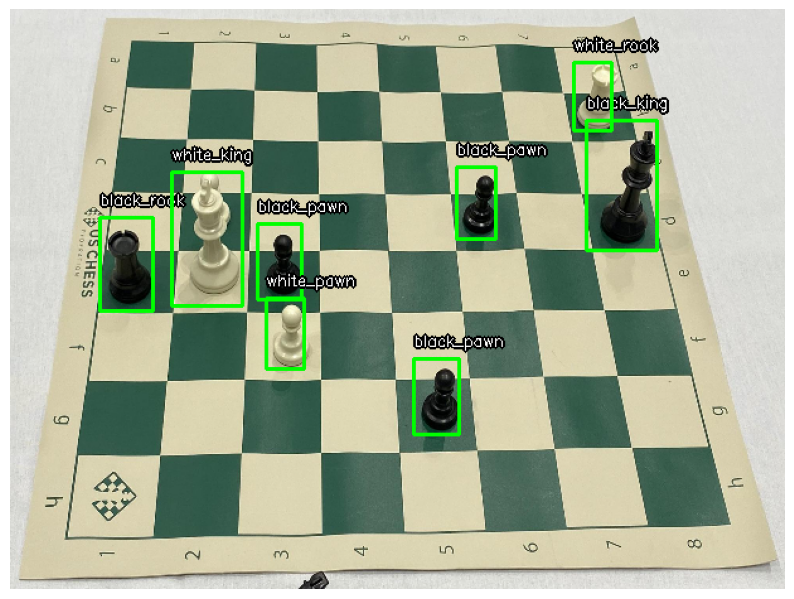

In [40]:
import os 

for filename in os.listdir("assets/good_images"):
    img_path = os.path.join("assets/good_images", filename)
    if os.path.isfile(img_path):
        detect_and_classify_pieces(img_path, 'best_svm_model.joblib', 'best_lda_transformer.joblib')

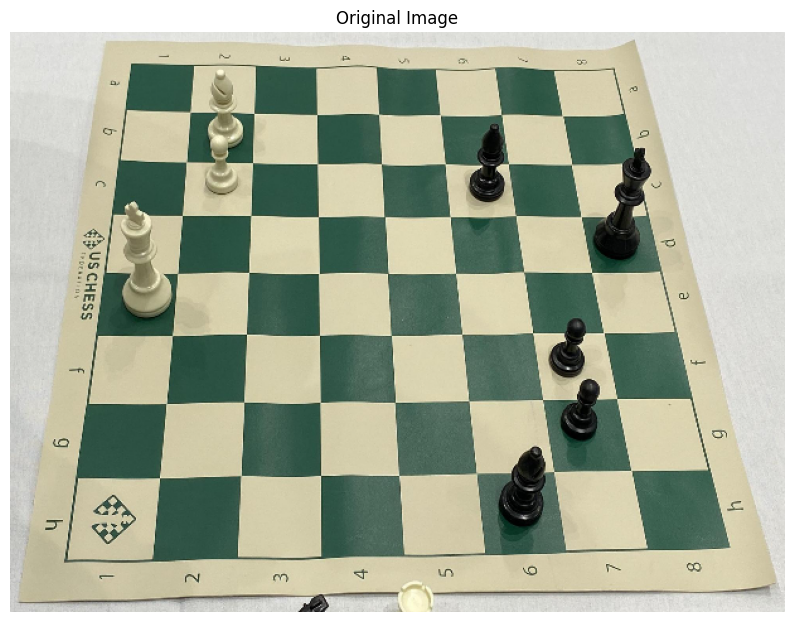

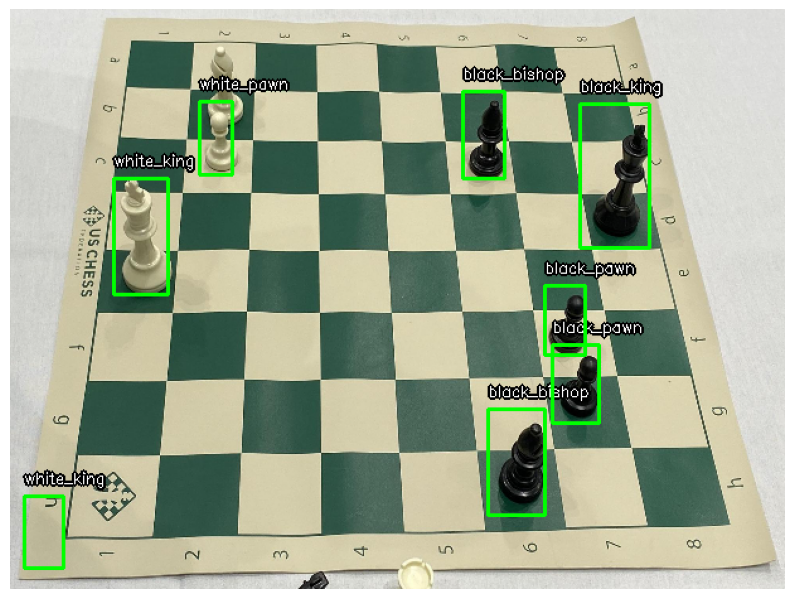

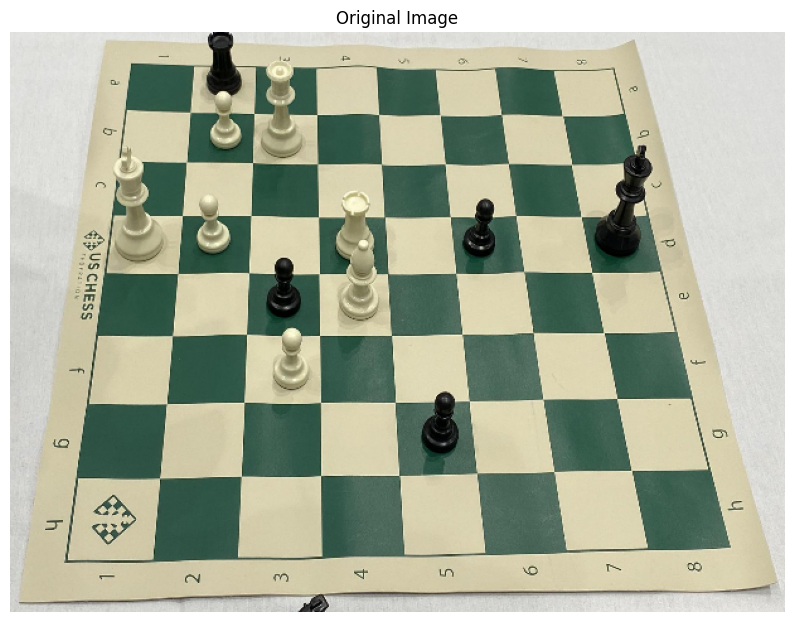

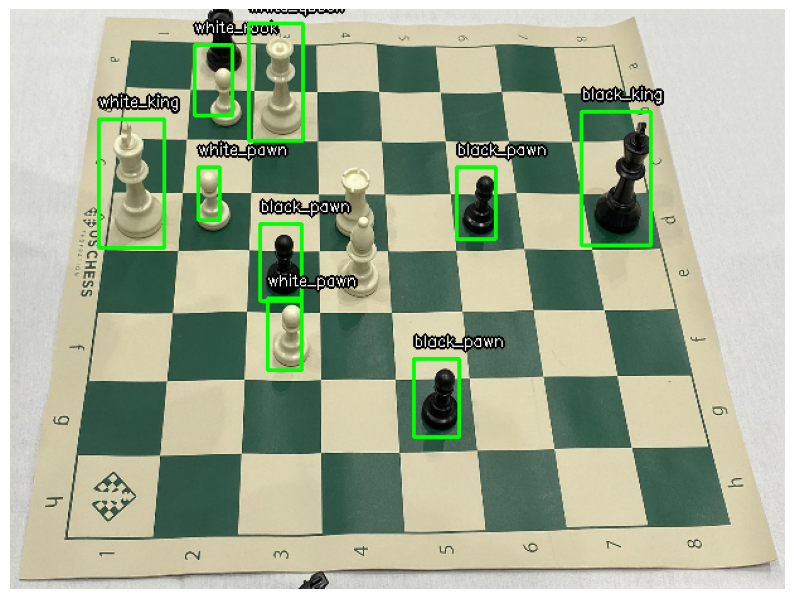

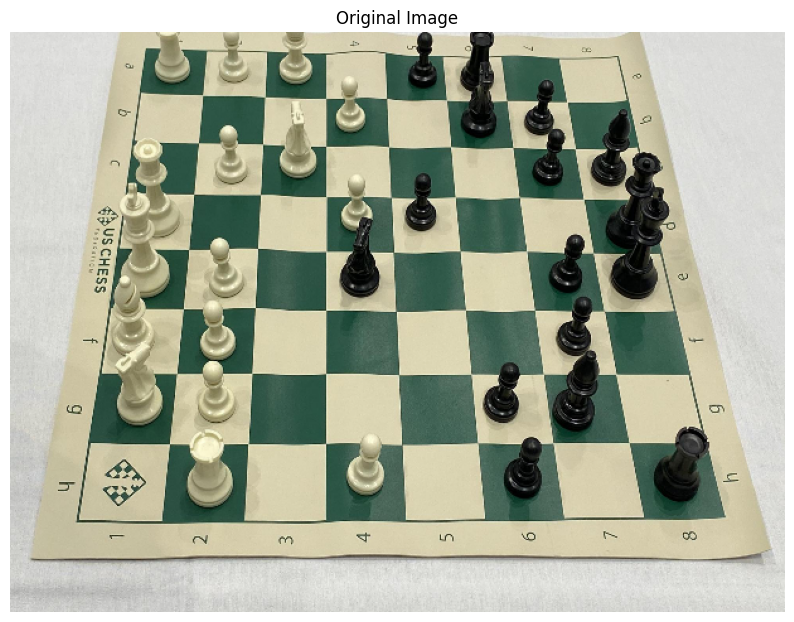

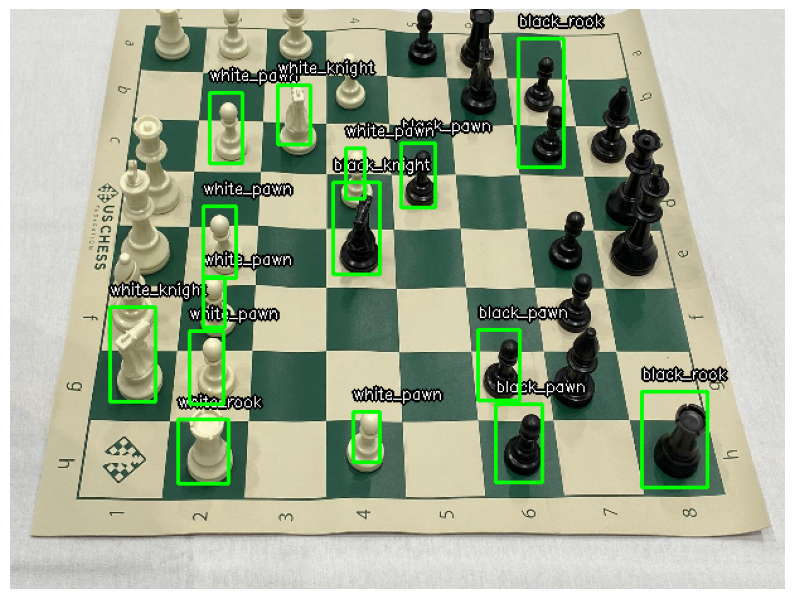

In [41]:
# Challenging examples
for filename in os.listdir("assets/challenging_images"):
    img_path = os.path.join("assets/challenging_images", filename)
    if os.path.isfile(img_path):
        detect_and_classify_pieces(img_path, 'best_svm_model.joblib', 'best_lda_transformer.joblib')